In [1]:
%matplotlib inline
import tvm
from tvm import te
import numpy as np
import d2ltvm

target = 'llvm'

successd...



In [2]:
sizes = 2 ** np.arange(5, 12, 1)
exe_times = [d2ltvm.bench_workload(d2ltvm.np_matmul_timer(n)) for n in sizes]
np_gflops = 2 * sizes ** 3 / 1e9 / exe_times

In [3]:
def default(n):
    A, B, C = d2ltvm.matmul(n, n, n)
    s = te.create_schedule(C.op)
    return s, (A, B, C)

s, args = default(64)
print(tvm.lower(s, args, simple_mode=True))

@main = primfn(A_1: handle, B_1: handle, C_1: handle) -> ()
  attr = {"from_legacy_te_schedule": True, "global_symbol": "main", "tir.noalias": True}
  buffers = {A: Buffer(A_2: Pointer(float32), float32, [4096], []),
             B: Buffer(B_2: Pointer(float32), float32, [4096], []),
             C: Buffer(C_2: Pointer(float32), float32, [4096], [])}
  buffer_map = {A_1: A, B_1: B, C_1: C}
  preflattened_buffer_map = {A_1: A_3: Buffer(A_2, float32, [64, 64], []), B_1: B_3: Buffer(B_2, float32, [64, 64], []), C_1: C_3: Buffer(C_2, float32, [64, 64], [])} {
  for (i: int32, 0, 64) {
    for (j: int32, 0, 64) {
      C[((i*64) + j)] = 0f32
      for (k: int32, 0, 64) {
        let cse_var_2: int32 = (i*64)
        let cse_var_1: int32 = (cse_var_2 + j)
        C[cse_var_1] = (C[cse_var_1] + (A[(cse_var_2 + k)]*B[((k*64) + j)]))
      }
    }
  }
}




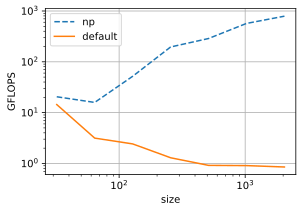

In [4]:
default_gflops = d2ltvm.bench_matmul_tvm(default, sizes, target)
d2ltvm.plot_gflops(sizes, [np_gflops, default_gflops], ['np', 'default'])

# BlockedMatrixMultiplication

1.Tile -> Fuse -> parallel

In [5]:
tx, ty, tk = 32, 32, 4
def tile(n):
    A, B, C = d2ltvm.matmul(n, n, n)
    s = te.create_schedule(C.op)
    xo, yo, xi, yi = s[C].tile(*C.op.axis, tx, ty)
    xy = s[C].fuse(xo, yo)
    s[C].parallel(xy)
    return s, (A, B, C)

s, args = tile(64)
print(tvm.lower(s, args, simple_mode=True))

@main = primfn(A_1: handle, B_1: handle, C_1: handle) -> ()
  attr = {"from_legacy_te_schedule": True, "global_symbol": "main", "tir.noalias": True}
  buffers = {A: Buffer(A_2: Pointer(float32), float32, [4096], []),
             B: Buffer(B_2: Pointer(float32), float32, [4096], []),
             C: Buffer(C_2: Pointer(float32), float32, [4096], [])}
  buffer_map = {A_1: A, B_1: B, C_1: C}
  preflattened_buffer_map = {A_1: A_3: Buffer(A_2, float32, [64, 64], []), B_1: B_3: Buffer(B_2, float32, [64, 64], []), C_1: C_3: Buffer(C_2, float32, [64, 64], [])} {
  for (i.outer.j.outer.fused: int32, 0, 4) "parallel" {
    for (i.inner: int32, 0, 32) {
      for (j.inner: int32, 0, 32) {
        C[((((floordiv(i.outer.j.outer.fused, 2)*2048) + (i.inner*64)) + (floormod(i.outer.j.outer.fused, 2)*32)) + j.inner)] = 0f32
        for (k: int32, 0, 64) {
          let cse_var_3: int32 = (floormod(i.outer.j.outer.fused, 2)*32)
          let cse_var_2: int32 = ((floordiv(i.outer.j.outer.fused, 2)*2048

In [9]:
tile_gflops = d2ltvm.bench_matmul_tvm(tile, sizes, target)

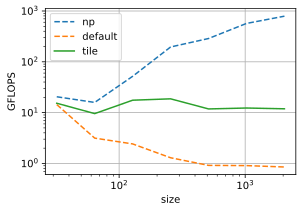

In [10]:
d2ltvm.plot_gflops(sizes, [np_gflops, default_gflops, tile_gflops], ['np', 'default', 'tile'])

2.reorder

In [11]:
def reorder(n):
    A, B, C = d2ltvm.matmul(n, n, n)
    s = te.create_schedule(C.op)
    # tile
    xo, yo, xi, yi = s[C].tile(*C.op.axis, tx, ty)
    xy = s[C].fuse(xo, yo)
    s[C].parallel(xy)
    (k,) = C.op.reduce_axis
    # reorder
    s[C].reorder(xi, k, yi)
    return s, (A, B, C)

s, args = reorder(64)
print(tvm.lower(s, args, simple_mode=True))

@main = primfn(A_1: handle, B_1: handle, C_1: handle) -> ()
  attr = {"from_legacy_te_schedule": True, "global_symbol": "main", "tir.noalias": True}
  buffers = {A: Buffer(A_2: Pointer(float32), float32, [4096], []),
             B: Buffer(B_2: Pointer(float32), float32, [4096], []),
             C: Buffer(C_2: Pointer(float32), float32, [4096], [])}
  buffer_map = {A_1: A, B_1: B, C_1: C}
  preflattened_buffer_map = {A_1: A_3: Buffer(A_2, float32, [64, 64], []), B_1: B_3: Buffer(B_2, float32, [64, 64], []), C_1: C_3: Buffer(C_2, float32, [64, 64], [])} {
  for (i.outer.j.outer.fused: int32, 0, 4) "parallel" {
    for (i.inner: int32, 0, 32) {
      for (j.inner.init: int32, 0, 32) {
        C[((((floordiv(i.outer.j.outer.fused, 2)*2048) + (i.inner*64)) + (floormod(i.outer.j.outer.fused, 2)*32)) + j.inner.init)] = 0f32
      }
      for (k: int32, 0, 64) {
        for (j.inner: int32, 0, 32) {
          let cse_var_3: int32 = (floormod(i.outer.j.outer.fused, 2)*32)
          let cse_va

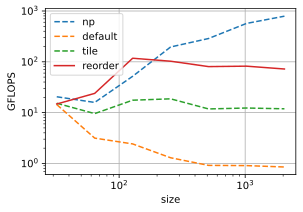

In [12]:
reorder_gflops = d2ltvm.bench_matmul_tvm(reorder, sizes, target)
d2ltvm.plot_gflops(sizes, [np_gflops, default_gflops, tile_gflops, reorder_gflops],
                  ['np', 'default', 'tile', 'reorder'])

3.optimizer the block

In [25]:
def block(n):
    A, B, C = d2ltvm.matmul(n, n, n)
    s = te.create_schedule(C.op)
    # tile
    xo, yo, xi, yi = s[C].tile(*C.op.axis, tx, ty)
    xy = s[C].fuse(xo, yo)
    s[C].parallel(xy)
    # optim block
    ko, ki = s[C].split(s[C].op.reduce_axis[0], factor=tk)
    s[C].reorder(ko, xi, ki, yi)
    s[C].vectorize(yi)
    s[C].unroll(ki)
    return s, (A, B, C)

s, args = block(64)
print(tvm.lower(s, args, simple_mode=True))

@main = primfn(A_1: handle, B_1: handle, C_1: handle) -> ()
  attr = {"from_legacy_te_schedule": True, "global_symbol": "main", "tir.noalias": True}
  buffers = {A: Buffer(A_2: Pointer(float32), float32, [4096], []),
             B: Buffer(B_2: Pointer(float32), float32, [4096], []),
             C: Buffer(C_2: Pointer(float32), float32, [4096], [])}
  buffer_map = {A_1: A, B_1: B, C_1: C}
  preflattened_buffer_map = {A_1: A_3: Buffer(A_2, float32, [64, 64], []), B_1: B_3: Buffer(B_2, float32, [64, 64], []), C_1: C_3: Buffer(C_2, float32, [64, 64], [])} {
  for (i.outer.j.outer.fused: int32, 0, 4) "parallel" {
    for (i.inner.init: int32, 0, 32) {
      C[ramp((((floordiv(i.outer.j.outer.fused, 2)*2048) + (i.inner.init*64)) + (floormod(i.outer.j.outer.fused, 2)*32)), 1, 32)] = broadcast(0f32, 32)
    }
    for (k.outer: int32, 0, 16) {
      for (i.inner: int32, 0, 32) {
        let cse_var_5: int32 = (floormod(i.outer.j.outer.fused, 2)*32)
        let cse_var_4: int32 = ((floordiv(i.

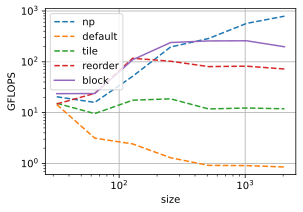

In [26]:
blocked_gflops = d2ltvm.bench_matmul_tvm(block, sizes, target)
d2ltvm.plot_gflops(sizes, [np_gflops, default_gflops, tile_gflops, reorder_gflops, blocked_gflops],
                  ['np', 'default', 'tile', 'reorder', 'block'])

4.WriteCache

In [29]:
def cached_block(n):
    A, B, C = d2ltvm.matmul(n, n, n)
    s = te.create_schedule(C.op)
    
    CachedC = s.cache_write(C, 'local')
    xo, yo, xi, yi = s[C].tile(*C.op.axis, tx, ty)
    xy = s[C].fuse(xo, yo)
    s[C].parallel(xy)
    s[CachedC].compute_at(s[C], xy)
    
    xc, yc = s[CachedC].op.axis
    ko, ki = s[CachedC].split(CachedC.op.reduce_axis[0], factor=tk)
    s[CachedC].reorder(ko, xc, ki, yc)
    s[CachedC].vectorize(yc)
    s[CachedC].unroll(ki)
    return s, (A, B, C)

s, args = cached_block(512)
print(tvm.lower(s, args, simple_mode=True))

@main = primfn(A_1: handle, B_1: handle, C_1: handle) -> ()
  attr = {"from_legacy_te_schedule": True, "global_symbol": "main", "tir.noalias": True}
  buffers = {A: Buffer(A_2: Pointer(float32), float32, [262144], []),
             B: Buffer(B_2: Pointer(float32), float32, [262144], []),
             C: Buffer(C_2: Pointer(float32), float32, [262144], [])}
  buffer_map = {A_1: A, B_1: B, C_1: C}
  preflattened_buffer_map = {A_1: A_3: Buffer(A_2, float32, [512, 512], []), B_1: B_3: Buffer(B_2, float32, [512, 512], []), C_1: C_3: Buffer(C_2, float32, [512, 512], [])} {
  for (i.outer.j.outer.fused: int32, 0, 256) "parallel" {
    allocate(C.local: Pointer(local float32), float32, [1024]), storage_scope = local {
      for (i.c.init: int32, 0, 32) {
        C.local_1: Buffer(C.local, float32, [1024], [], scope="local")[ramp((i.c.init*32), 1, 32)] = broadcast(0f32, 32)
      }
      for (k.outer: int32, 0, 128) {
        for (i.c: int32, 0, 32) {
          let cse_var_3: int32 = (i.c*32)
 

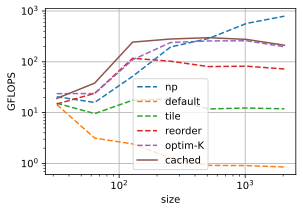

In [30]:
cached_gflops = d2ltvm.bench_matmul_tvm(cached_block, sizes, target)
d2ltvm.plot_gflops(sizes, [np_gflops, default_gflops, tile_gflops, reorder_gflops, blocked_gflops, cached_gflops],
                  ['np', 'default', 'tile', 'reorder', 'optim-K', 'cached'])

# Summary
1.Blocked tiling improves cache efficiency for matrix multiplication. \
2.Data to be frequently read and written should be placed in a buffer explicitly to reduce cache misses.